# **Predicting Song Popularity Using Spotify Audio Features**

Firstly, it imports required libraries such as Pandas for data manipulation, Seaborn and Matplotlib for visualization, NumPy for numerical computations, Statsmodels for statistical analysis, and scikit-learn for machine learning. Then, it loads the dataset,subsequently, it displaying basic information about the dataset including column names, data types, and memory usage. Following this, it checks for missing values and duplicate rows within the dataset.

After identifying unnecessary columns like 'explicit' and 'track_id', it removes them. Additionally, it drops any columns with names containing 'Unnamed'. These steps collectively ensure the dataset is properly cleaned and prepared for subsequent analysis or modeling tasks.

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
import random
from scipy import stats

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import resample

import csv

# Load the dataset with specified encoding and custom parsing parameters
df = pd.read_csv("/content/dataset.csv", encoding='latin1', sep=',')  # or adjust sep, delimiter, quotechar as needed

# Display basic information about the dataset
print(df.info())

# Check for missing values
print(df.isnull().sum())

# Check for duplicate rows
print(df.duplicated().sum())

# Remove rows with missing values
df_cleaned = df.dropna()

# Remove rows with infinite values
df_cleaned = df_cleaned[~df_cleaned.isin([np.inf, -np.inf]).any(axis=1)]

# Drop columns we don't need
columns_to_drop = ['explicit', 'track_id', 'album_name', 'track_name']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Drop the unnamed column
df = df.drop(columns=[col for col in df.columns if 'Unnamed' in col])

df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

,artists,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,Gen Hoshino,73,230666,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,Ben Woodward,55,149610,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,Ingrid Michaelson;ZAYN,57,210826,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,Kina Grannis,71,201933,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,Chord Overstreet,82,198853,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,Rainy Lullaby,21,384999,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music
113996,Rainy Lullaby,22,385000,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music
113997,CesÃ¡ria Evora,22,271466,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music
113998,Michael W. Smith,41,283893,0.587,0.5060,7,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music


In [56]:
df.describe()

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,114000.000000,1.140000e+05,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000
mean,33.238535,2.280292e+05,0.566800,0.641383,5.309140,-8.258960,0.637553,0.084652,0.314910,0.156050,0.213553,0.474068,122.147837,3.904035
std,22.305078,1.072977e+05,0.173542,0.251529,3.559987,5.029337,0.480709,0.105732,0.332523,0.309555,0.190378,0.259261,29.978197,0.432621
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,1.740660e+05,0.456000,0.472000,2.000000,-10.013000,0.000000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218750,4.000000
50%,35.000000,2.129060e+05,0.580000,0.685000,5.000000,-7.004000,1.000000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000,4.000000
75%,50.000000,2.615060e+05,0.695000,0.854000,8.000000,-5.003000,1.000000,0.084500,0.598000,0.049000,0.273000,0.683000,140.071000,4.000000
max,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


In [57]:
# Print stats for various metrics
print(f"There are {df.shape[0]} rows")
print(f"There are {df['artists'].nunique()} unique artists")
print(f"There are {df['popularity'].nunique()} popularity scores")
print(f"The mean popularity score is {df['popularity'].mean()}")
print(f"There are {df[df['popularity'] > 55]['popularity'].count()} songs with a popularity score > 55")
print(f"There are {df[df['popularity'] > 75]['popularity'].count()} songs with a popularity score > 75")
print(f"Only {(df[df['popularity'] > 80]['popularity'].count() / df.shape[0])*100:.2f} % of songs have a popularity score > 80")

There are 114000 rows
There are 31437 unique artists
There are 101 popularity scores
The mean popularity score is 33.2385350877193
There are 20545 songs with a popularity score > 55
There are 2414 songs with a popularity score > 75
Only 0.84 % of songs have a popularity score > 80


# **Data Exploration**

Upon examining the distribution of popularity scores, it became evident that the majority of songs within the dataset are not highly popular. Specifically, a significant portion of songs have a popularity score below 40, with the mean popularity score resting at 33. This observation highlights the dataset's imbalance, where only 18% of songs possess a popularity score exceeding 55. The subsequent figure visually depicts this skew in popularity distribution.

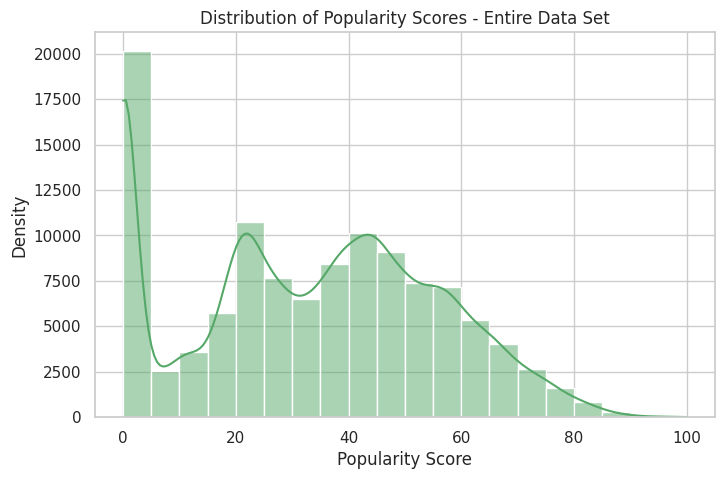

In [58]:
def plot_pop_dist(df):
    # set palette
    sns.set_palette('muted')

    # create initial figure
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)

    # Plot distribution of popularity scores
    sns.histplot(df['popularity'], bins=20, kde=True, color='g', label="Popularity")

    # Set title and axis labels
    plt.title('Distribution of Popularity Scores - Entire Data Set')
    plt.xlabel('Popularity Score')
    plt.ylabel('Density')

    plt.show()

plot_pop_dist(df)

In [59]:
# Total number of songs
total_songs = df.shape[0]

# Counting the number of songs with popularity score above 55
above_55_count = df[df['popularity'] > 55].shape[0]

# Calculating the percentage
percentage_above_55 = (above_55_count / total_songs) * 100

print("Percentage of songs with a popularity score above 55:", percentage_above_55, "%")


Percentage of songs with a popularity score above 55: 18.021929824561404 %


Continuing our exploration of the dataset as a whole, we recognized the potential difficulty for linear regression to effectively solve the problem. This arises from the observation that many features display limited correlation with the target variable. To illustrate this, we created scatter plots showcasing selected features plotted against popularity scores. Notably, we applied a hue to differentiate popularity scores above 55, enhancing the visual contrast in the plots.

<ipython-input-60-57d1d46fee22>:12: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



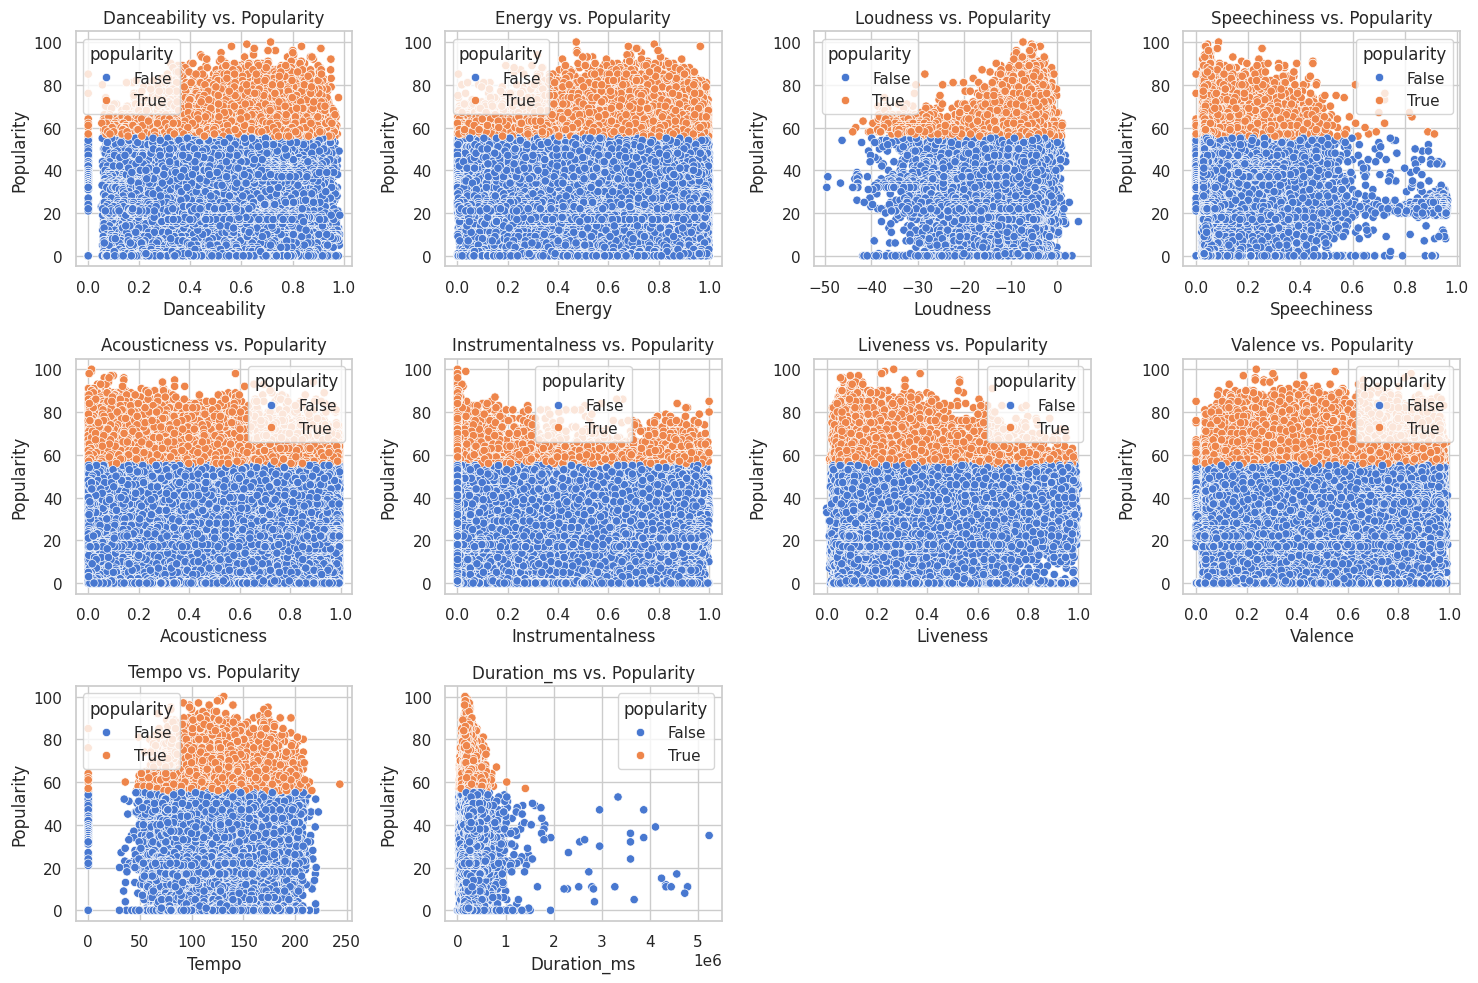

In [60]:
# Scatter plots of features vs. popularity
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
            'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

plt.figure(figsize=(15, 10))
for feature in features:
    plt.subplot(3, 4, features.index(feature) + 1)
    sns.scatterplot(data=df, x=feature, y='popularity', hue=df['popularity'] > 55)
    plt.title(f"{feature.capitalize()} vs. Popularity")
    plt.xlabel(feature.capitalize())
    plt.ylabel("Popularity")
plt.tight_layout()
plt.show()

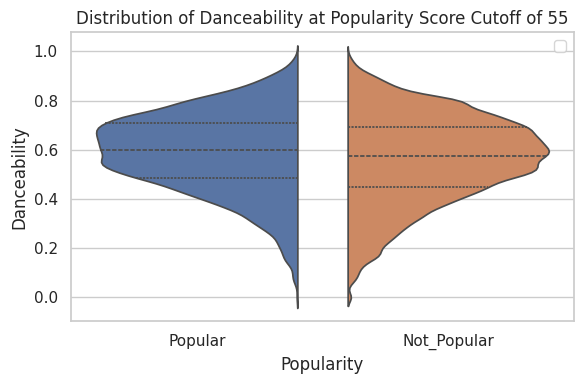

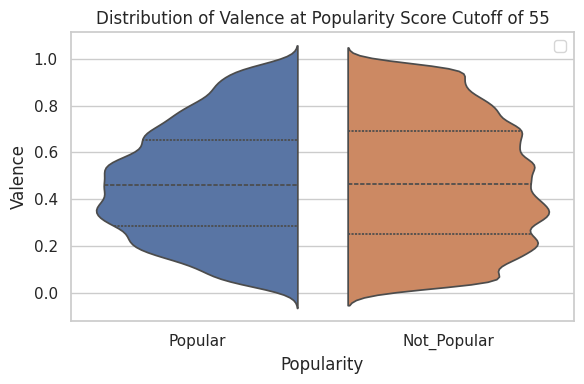

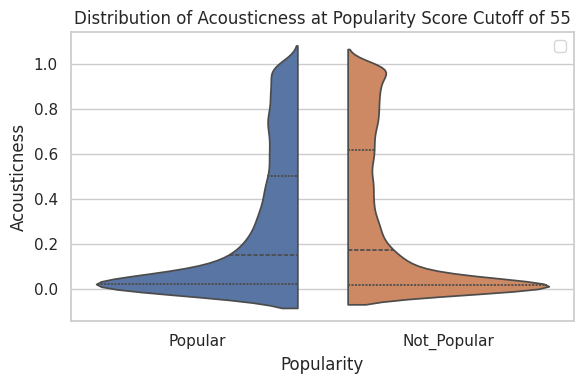

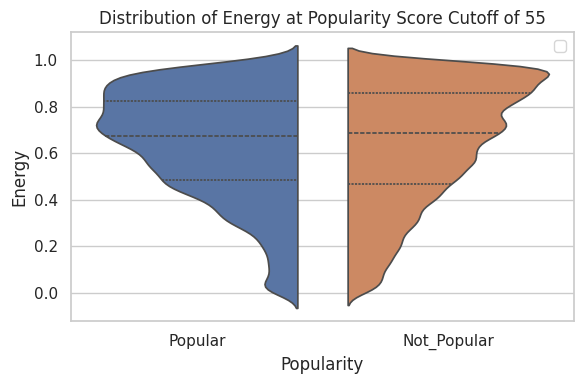

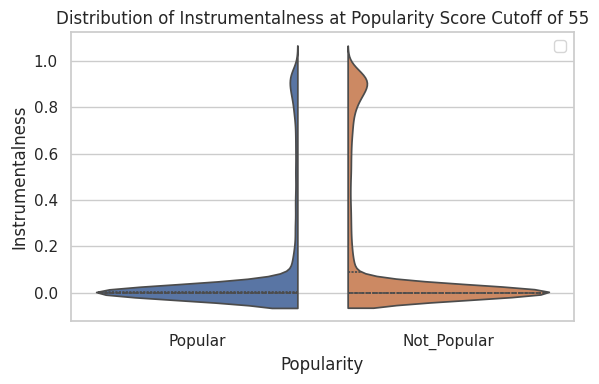

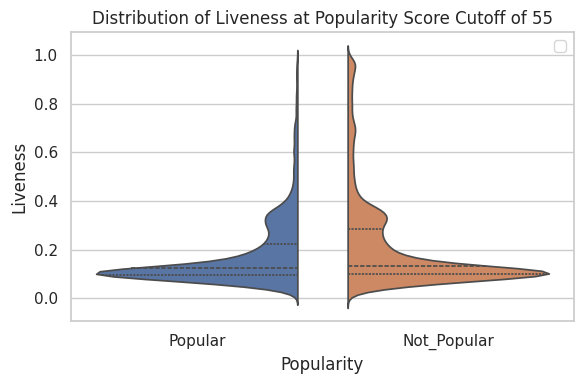

In [61]:
def plot_violin_by_feature(df, feature, cutoff):
    df = df.copy()
    sns.set(style="whitegrid")
    df['pop_bin'] = np.where(df['popularity'] > cutoff, "Popular", "Not_Popular")

    plt.figure(figsize=(6, 4))
    sns.violinplot(x=df['pop_bin'], y=df[feature], hue=df['pop_bin'], split=True, inner='quartile')
    plt.title(f'Distribution of {feature.capitalize()} at Popularity Score Cutoff of {cutoff}')
    plt.xlabel('Popularity')
    plt.ylabel(feature.capitalize())
    plt.legend(title=None)
    plt.tight_layout()
    plt.show()

# Example usage:
features = ['danceability', 'valence', 'acousticness', 'energy', 'instrumentalness', 'liveness']
cutoff = 55
for feature in features:
    plot_violin_by_feature(df, feature, cutoff)

We can also demonstrate this concept by choosing a specific popularity cutoff, such as 55, and then plotting the means of certain independent variables along with their distributions. As depicted in the figure below, the average values of these independent variables between songs classified as 'popular' and 'unpopular' are relatively similar.

We used sns to create a heatmap of our data. However we noticed there is not much correlation between independent variables and popularity. This might have many consequences when fitting a linear model.

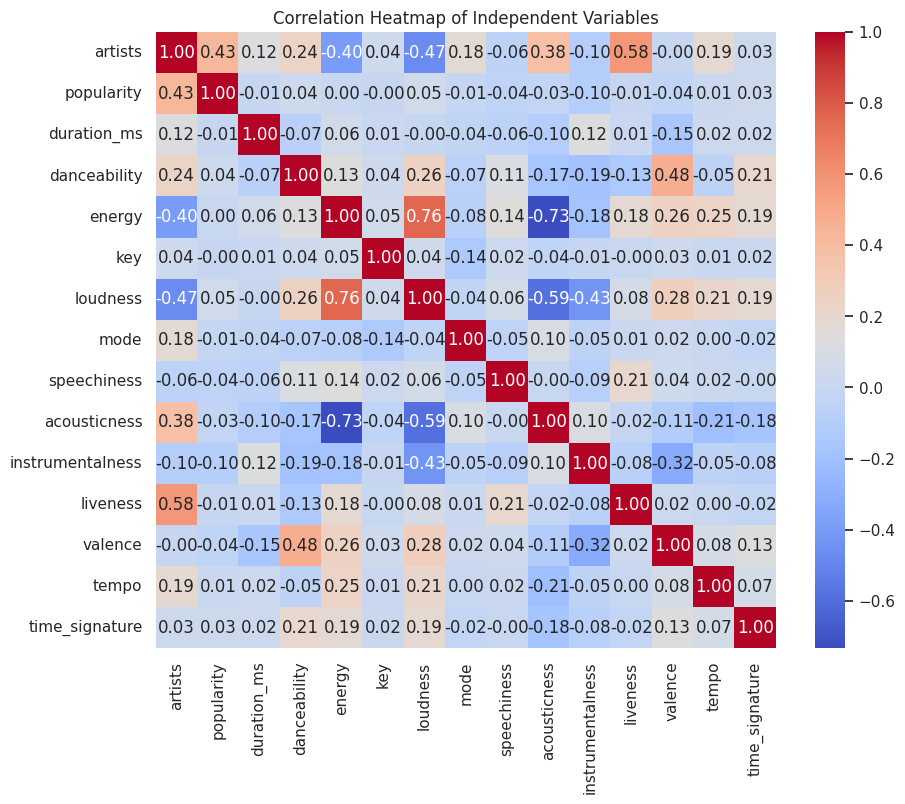

In [62]:
# Convert all columns to numeric format
df_numeric = df.apply(pd.to_numeric, errors='coerce')

# Drop non-numeric columns
df_numeric.dropna(axis=1, how='all', inplace=True)  # Drop columns where all values are NaN

# Check if there are still columns left after dropping
if df_numeric.empty:
    print("No numeric columns left after conversion.")
else:
    # Check multicollinearity with heatmap
    correlation_matrix = df_numeric.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Heatmap of Independent Variables")
    plt.show()

Distribution of dependent variable is quite unbalanced, and this will make it difficult for a model to predict the very popular songs, because there are less popular songs to train on.
Only 0.84% of songs have a popularity score > 80.
Undersampling might be crucial to creating a good model.
No actual null values, but plenty of zeros for each feature, which could be interpreted as missing data.
Almost 1/10 of the songs have a popularity score of zero. This could cause problems when training the model
Heatmap shows some potential multicollinearity between energy and valence.

# **Data Driven Prediction**

# **Linear Regression**
In our initial modeling attempt, we chose linear regression to predict song popularity scores due to observed correlations between 13 independent variables and the dependent variable. We employed train-test-split to divide the dataset, allocating 20% for testing. Through iterative experimentation involving feature adjustments and data transformations, we sought to enhance the initially low R^2 values.

However, despite these efforts, the initial model yielded disappointing R^2 values of approximately 0.02. Even removing songs with zero popularity scores failed to substantially improve R^2. While we recognize R^2's limitations, it served as an initial metric for assessing model performance.

Additionally, the QQ plot was employed to evaluate the normality assumption of the residuals. It compares the residuals' quantiles to a theoretical normal distribution. Ideally, if the residuals adhere to normality, the plot points will align along a straight line. Any deviations indicate non-normality, which could undermine the linear regression model's reliability.

Size checks for the new dataframe:
Shape of the new undersampled dataframe: (114000, 17)
pop_bin
Not_Popular    93455
Popular        20545
Name: count, dtype: int64
Mean danceability for Popular tracks: 0.589047174495011
Mean danceability for Not_Popular tracks: 0.5619092964528383
Count of Popular tracks: 20545
Count of Not_Popular tracks: 93455
                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     208.5
Date:                Sat, 20 Apr 2024   Prob (F-statistic):               0.00
Time:                        08:41:47   Log-Likelihood:            -5.1437e+05
No. Observations:              114000   AIC:                         1.029e+06
Df Residuals:                  113986   BIC:                         1.029e+06
Df Model:           

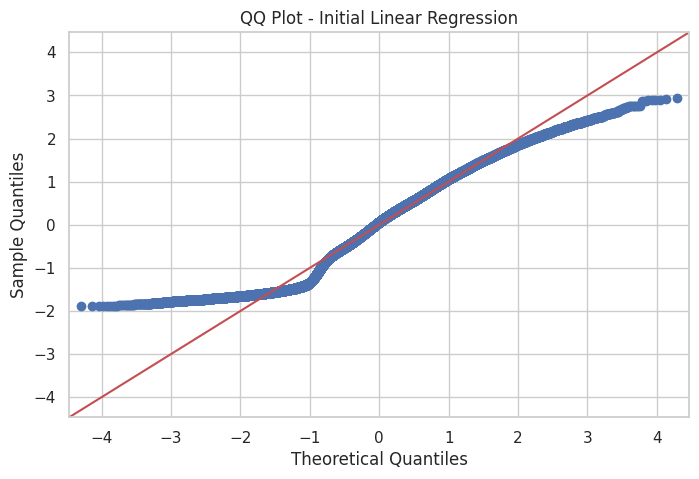

Non-numeric columns: Index(['artists', 'track_genre', 'pop_bin'], dtype='object')
Training R^2 Score: 0.023777754888221092
Testing R^2 Score: 0.020792259154221227
Training Mean Squared Error: 486.65719680016804
Testing Mean Squared Error: 483.2203028162697


In [63]:
def train_and_evaluate_linear_regression(df, cutoff):
    # Define independent variables matrix X
    X = df[['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']]
    # Add a constant to the independent variables matrix (for intercept term)
    X = sm.add_constant(X)

    df['pop_bin'] = np.where(df['popularity'] > cutoff, "Popular", "Not_Popular")

    # Define dependent variable vector y
    y = df['popularity']

    # Fit the OLS model
    model = sm.OLS(y, X)
    results = model.fit()

    # Print the summary of the regression results
    print("Size checks for the new dataframe:")
    print("Shape of the new undersampled dataframe:", df.shape)
    print(df['pop_bin'].value_counts())
    print("Mean danceability for Popular tracks:", df[df['pop_bin'] == 'Popular']['danceability'].mean())
    print("Mean danceability for Not_Popular tracks:", df[df['pop_bin'] == 'Not_Popular']['danceability'].mean())
    print("Count of Popular tracks:", df[df['pop_bin'] == 'Popular']['danceability'].count())
    print("Count of Not_Popular tracks:", df[df['pop_bin'] == 'Not_Popular']['danceability'].count())
    print(results.summary())

    # Get residuals
    residuals = results.resid

    # QQ Plot
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.title("QQ Plot - Initial Linear Regression")
    fig = sm.qqplot(residuals, line='45', fit=True, ax=ax)
    plt.show()

    # Check for non-numeric columns
    non_numeric_columns = df.select_dtypes(exclude=['float', 'int']).columns
    print("Non-numeric columns:", non_numeric_columns)

    # Drop non-numeric columns for simplicity
    df_numeric = df.drop(columns=non_numeric_columns)

    # Handle missing values
    df_numeric.dropna(inplace=True)

    # Splitting the dataset into train and test sets
    X = df_numeric.drop(columns=['popularity'])
    y = df_numeric['popularity']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initializing linear regression model
    model = LinearRegression()

    # Training the model
    model.fit(X_train, y_train)

    # Making predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculating R^2 scores
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    # Calculate Mean Squared Error
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)

    # Output the results
    print("Training R^2 Score:", train_r2)
    print("Testing R^2 Score:", test_r2)
    print("Training Mean Squared Error:", train_mse)
    print("Testing Mean Squared Error:", test_mse)

    # Return R^2 scores and MSE
    return train_r2, test_r2, train_mse, test_mse

# Define cutoff value
cutoff = 55

# Call the function with the cutoff value
otrain_r2, otest_r2, otrain_mse, otest_mse = train_and_evaluate_linear_regression(df, cutoff)


Even though the R^2 is low, there are still some important takeaways from this model, as we can take a look at the magnitudes of the coefficient values. The most important features appear to be:danceability,energy,instrumentalness, speechiness and valence.

Coefficients: These are the estimated coefficients (or slopes) of the independent variables in the regression equation. They represent the change in the dependent variable for a one-unit change in the independent variable, holding all other variables constant. For example, the coefficient for 'danceability' is 8.5550, meaning that for every one-unit increase in danceability, the predicted popularity score increases by approximately 8.5550 points, holding all other variables constant.

# **Undersampling**

As mentioned earlier, the main challenge with our initial approach was the difficulty in predicting the highest and lowest popularity values due to the unbalanced nature of the dataset. However, after discussing this issue with colleagues, we concluded that undersampling the data could be a suitable strategy for dealing with an unbalanced dataset like ours.

Undersampling involves balancing the ratio of important and unimportant dependent variable values, aiming to expose the model to more relevant values. This is achieved by first selecting a subset of the data containing all important dependent variable values, which we define as the cutoff point.

Essentially, all values with a popularity score greater than or equal to the cutoff are included in the model, while the data with popularity scores below the cutoff point are randomly sampled to achieve a 50/50 split of popular and unpopular songs in the final dataset. This process is illustrated in the figure.

<ipython-input-64-92d95c6ecf00>:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




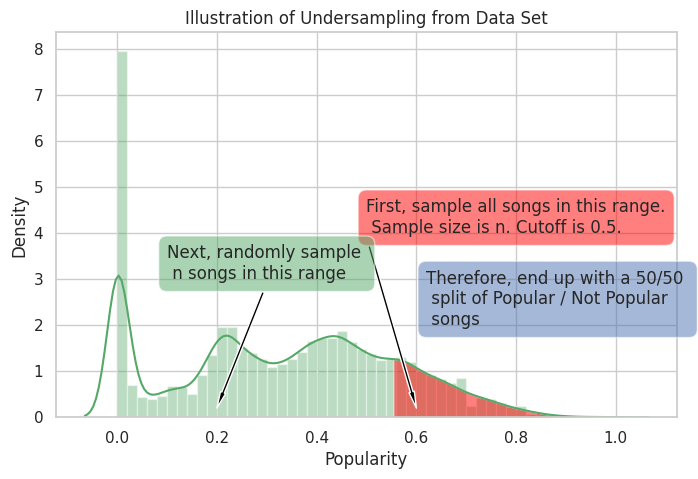

In [64]:
# set palette
sns.set_palette('muted')

# create initial figure
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
sns.distplot(df['popularity']/100, color='g', label="Popularity").set_title("Illustration of Undersampling from Data Set")

# create line to shade to the right of
line = ax.get_lines()[-1]
x_line, y_line = line.get_data()
mask = x_line > 0.55
x_line, y_line = x_line[mask], y_line[mask]
ax.fill_between(x_line, y1=y_line, alpha=0.5, facecolor='red')

# get values for and plot first label
label_x = 0.5
label_y = 4
arrow_x = 0.6
arrow_y = 0.2

arrow_properties = dict(
    facecolor="black", width=2,
    headwidth=4,connectionstyle='arc3,rad=0')

plt.annotate(
    "First, sample all songs in this range.\n Sample size is n. Cutoff is 0.5.", xy=(arrow_x, arrow_y),
    xytext=(label_x, label_y),
    bbox=dict(boxstyle='round,pad=0.5', fc='red', alpha=0.5),
    arrowprops=arrow_properties)

# Get values for and plot second label
label_x = 0.1
label_y = 3
arrow_x = 0.2
arrow_y = 0.2

arrow_properties = dict(
    facecolor="black", width=2,
    headwidth=4,connectionstyle='arc3,rad=0')

plt.annotate(
    "Next, randomly sample \n n songs in this range", xy=(arrow_x, arrow_y),
    xytext=(label_x, label_y),
    bbox=dict(boxstyle='round,pad=0.5', fc='g', alpha=0.5),
    arrowprops=arrow_properties)

# plot final word box
plt.annotate(
    "Therefore, end up with a 50/50 \n split of Popular / Not Popular\n songs", xy=(0.6, 2),
    xytext=(0.62, 2),
    bbox=dict(boxstyle='round,pad=0.5', fc='b', alpha=0.5))

# create x and y axis labels
plt.xlabel("Popularity")
plt.ylabel("Density")

plt.show()


The next phase of our analysis predominantly revolved around exploring how R^2 values and the coefficients of variables evolved with changes in the cutoff value. Firstly, we began by selecting a specific cutoff value for popularity. Next, we collected all songs with popularity scores equal to or exceeding this cutoff value. Then, to balance the dataset, we randomly sampled a subset of songs with popularity scores below the cutoff. Subsequently, utilizing this balanced dataset, we constructed a linear regression model. Finally, we examined the R^2 values obtained from this model to assess its predictive performance.

In [65]:
def random_under_sampler(df, cutoff):
    # Create a copy of the original dataframe
    df_original = df.copy()

    # Create a new column 'pop_bin' based on the popularity cutoff
    df_original['pop_bin'] = np.where(df_original['popularity'] > cutoff, "Popular", "Not_Popular")

    # Create a dataframe containing only popular tracks
    df_small = df_original[df_original['popularity'] > cutoff].copy()

    # Create a dataframe to store sampled rows
    df_samples_added = df_small.copy()

    # Initialize the total count
    total = df_small.shape[0] + 1

    # Loop through and add random unpopular rows to the sampled dataframe
    while total <= df_small.shape[0] * 2:
        # Pick a random row from the original dataframe
        rand_row = random.randint(0, df_original.shape[0] - 1)

        # Check if the randomly selected row is not popular
        if df_original.loc[rand_row, 'pop_bin'] == "Not_Popular":
            # Add the row to the sampled dataframe
            df_samples_added.loc[total] = df_original.loc[rand_row, :]
            total += 1

    # Return the undersampled dataframe
    return df_samples_added


For Popularity cutoff of 70
Size checks for the new dataframe:
Shape of the new undersampled dataframe: (9613, 17)
pop_bin
Not_Popular    4846
Popular        4767
Name: count, dtype: int64
Mean danceability for Popular tracks: 0.6197491084539543
Mean danceability for Not_Popular tracks: 0.5633176846884028
Count of Popular tracks: 4767
Count of Not_Popular tracks: 4846
                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     93.63
Date:                Sat, 20 Apr 2024   Prob (F-statistic):          5.43e-237
Time:                        08:42:34   Log-Likelihood:                -44877.
No. Observations:                9613   AIC:                         8.978e+04
Df Residuals:                    9599   BIC:                         8.988e+

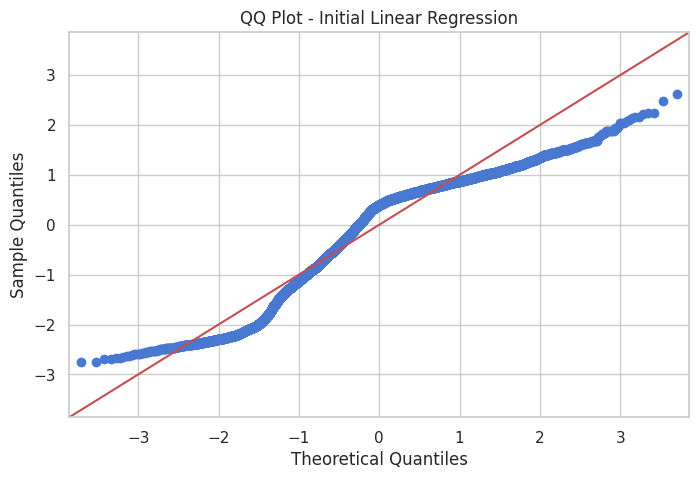

Non-numeric columns: Index(['artists', 'track_genre', 'pop_bin'], dtype='object')
Training R^2 Score: 0.11160869334163592
Testing R^2 Score: 0.11511525412672718
Training Mean Squared Error: 661.4715734308612
Testing Mean Squared Error: 676.4667795491874
 
 
For Popularity cutoff of 80
Size checks for the new dataframe:
Shape of the new undersampled dataframe: (1908, 17)
pop_bin
Popular        954
Not_Popular    954
Name: count, dtype: int64
Mean danceability for Popular tracks: 0.6581111111111111
Mean danceability for Not_Popular tracks: 0.5650763102725367
Count of Popular tracks: 954
Count of Not_Popular tracks: 954
                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     31.15
Date:                Sat, 20 Apr 2024   Prob (F-statistic):

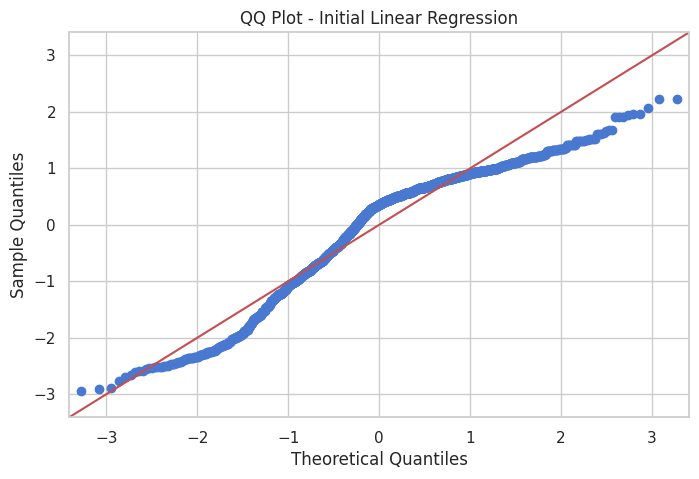

Non-numeric columns: Index(['artists', 'track_genre', 'pop_bin'], dtype='object')
Training R^2 Score: 0.18754879924727896
Testing R^2 Score: 0.12423420877253066
Training Mean Squared Error: 772.9224816216156
Testing Mean Squared Error: 841.1681872443778
 
 
For Popularity cutoff of 85
Size checks for the new dataframe:
Shape of the new undersampled dataframe: (542, 17)
pop_bin
Popular        271
Not_Popular    271
Name: count, dtype: int64
Mean danceability for Popular tracks: 0.6861660516605167
Mean danceability for Not_Popular tracks: 0.5761402214022141
Count of Popular tracks: 271
Count of Not_Popular tracks: 271
                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     13.69
Date:                Sat, 20 Apr 2024   Prob (F-statistic): 

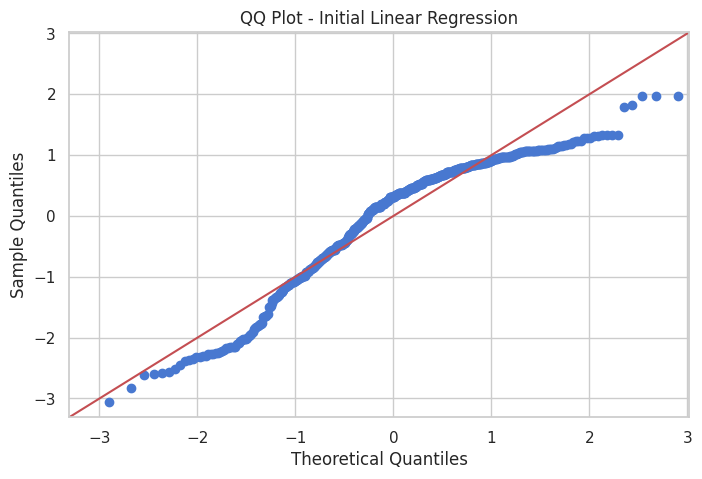

Non-numeric columns: Index(['artists', 'track_genre', 'pop_bin'], dtype='object')
Training R^2 Score: 0.25192424330725416
Testing R^2 Score: 0.22437604013391033
Training Mean Squared Error: 806.7740540616771
Testing Mean Squared Error: 858.6909945443837
 
 
For Popularity cutoff of 90
Size checks for the new dataframe:
Shape of the new undersampled dataframe: (136, 17)
pop_bin
Popular        68
Not_Popular    68
Name: count, dtype: int64
Mean danceability for Popular tracks: 0.7209117647058825
Mean danceability for Not_Popular tracks: 0.5470588235294118
Count of Popular tracks: 68
Count of Not_Popular tracks: 68
                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     6.438
Date:                Sat, 20 Apr 2024   Prob (F-statistic):     

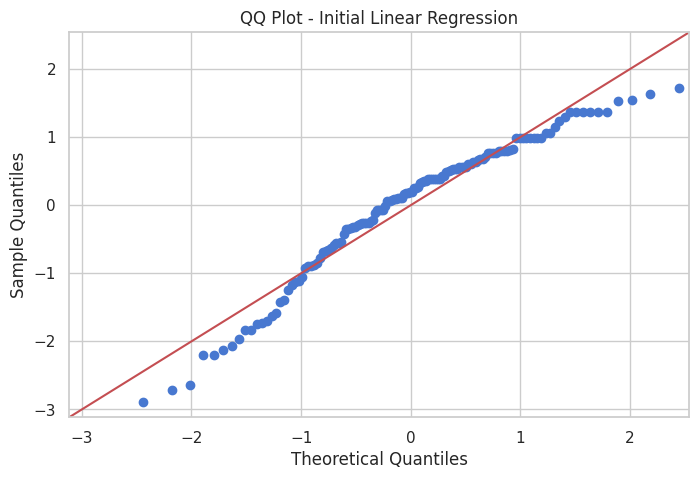

Non-numeric columns: Index(['artists', 'track_genre', 'pop_bin'], dtype='object')
Training R^2 Score: 0.44643894098348025
Testing R^2 Score: 0.059438821361075034
Training Mean Squared Error: 662.3817473657631
Testing Mean Squared Error: 997.32116650087
 
 

Results Table:
   Cutoff  Train R^2  Test R^2   Train MSE    Test MSE
0      70   0.111609  0.115115  661.471573  676.466780
1      80   0.187549  0.124234  772.922482  841.168187
2      85   0.251924  0.224376  806.774054  858.690995
3      90   0.446439  0.059439  662.381747  997.321167


In [66]:
# Store R^2 scores and MSE for different cutoff values
results_dict = {'Cutoff': [], 'Train R^2': [], 'Test R^2': [], 'Train MSE': [], 'Test MSE': []}

# Initialize variables to store values for cutoff 85
trainu_r2, testu_r2, trainu_mse, testu_mse = None, None, None, None

# Loop through different cutoff values
for cutoff in [70, 80, 85, 90]:
    print("For Popularity cutoff of", cutoff)
    df_samples = random_under_sampler(df, cutoff)
    train_r2, test_r2, train_mse, test_mse = train_and_evaluate_linear_regression(df_samples, cutoff)

    # If cutoff is 85, assign values to trainu and testu variables
    if cutoff == 85:
        trainu_r2, testu_r2, trainu_mse, testu_mse = train_r2, test_r2, train_mse, test_mse

    results_dict['Cutoff'].append(cutoff)
    results_dict['Train R^2'].append(train_r2)
    results_dict['Test R^2'].append(test_r2)
    results_dict['Train MSE'].append(train_mse)
    results_dict['Test MSE'].append(test_mse)
    print(" ")
    print(" ")

# Print the results table
print("\nResults Table:")
results_df = pd.DataFrame(results_dict)
print(results_df)


In our evaluation of the final linear regression model, we opted for a cutoff of 85. This choice struck a balance between achieving a higher R^2 value while preserving the significance of crucial predictors. Nonetheless, the model's performance was underwhelming, lacking the accuracy required for predicting popularity scores reliably. Despite these limitations, our analysis revealed that certain features, such as danceability, energy, instrumentalness, loudness, speechiness, and valence, remained the most vital and statistically significant.

# **Random Forest Regression Model**

In the code we implemented a Random Forest regression model for predictive modeling. It begins by preparing the dataset, separating it into majority and minority classes based on a predefined popularity cutoff. The majority class is then downsampled to match the size of the minority class. Features and the target variable are defined, followed by splitting the data into training and testing sets. A Random Forest regressor is instantiated with default parameters. Hyperparameter tuning is performed using Grid Search Cross-Validation to find the optimal combination of hyperparameters, including the number of trees (`n_estimators`), maximum depth of trees (`max_depth`), and minimum samples required at a leaf node (`min_samples_leaf`). The best model obtained from the grid search is trained on the training data, and predictions are made on the testing set. Mean Squared Error and R-squared are calculated to evaluate the model's performance. This workflow provides a structured approach to building and optimizing Random Forest regression models, suitable for various predictive modeling tasks.

In [67]:
# Define the cutoff for popularity
cutoff = 85

# Separate majority and minority classes
majority_class = df[df['popularity'] < cutoff]
minority_class = df[df['popularity'] >= cutoff]

# Undersample majority class to match minority class
majority_downsampled = resample(majority_class,
                                replace=False,    # sample without replacement
                                n_samples=len(minority_class),    # match minority class size
                                random_state=42)  # reproducible results

# Combine minority class and downsampled majority class
df_downsampled = pd.concat([majority_downsampled, minority_class])

# Define features (X) and target variable (y) after downsampling
X_downsampled = df_downsampled[['acousticness', 'danceability', 'duration_ms', 'energy',
                                'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
                                'speechiness', 'tempo', 'time_signature', 'valence']]
y_downsampled = df_downsampled['popularity']

# Split the downsampled data into training and testing sets
X_train_downsampled, X_test_downsampled, y_train_downsampled, y_test_downsampled = train_test_split(
    X_downsampled, y_downsampled, test_size=0.2, random_state=42)

# Define the Random Forest model with default parameters
rf_model = RandomForestRegressor(random_state=42)

# Define the hyperparameters grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],      # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],       # Maximum depth of the tree
    'min_samples_leaf': [1, 2, 4]          # Minimum number of samples required to be at a leaf node
}

# Perform Grid Search Cross-Validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_downsampled, y_train_downsampled)

# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the testing set using the best model
y_pred_downsampled_best = best_model.predict(X_test_downsampled)

# Calculate Mean Squared Error and R-squared
mse_downsampled_best = mean_squared_error(y_test_downsampled, y_pred_downsampled_best)
r2_downsampled_best = r2_score(y_test_downsampled, y_pred_downsampled_best)

print("Best Hyperparameters:", best_params)
print("Mean Squared Error on downsampled data (after tuning):", mse_downsampled_best)
print("R-squared on downsampled data (after tuning):", r2_downsampled_best)



Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 100}
Mean Squared Error on downsampled data (after tuning): 450.91193904950507
R-squared on downsampled data (after tuning): 0.5275851748677843


In [68]:
# Data for linear regression and random forest
names = ['Linear Regression (Original)', 'Linear Regression (Undersampled)', 'Random Forest']
mse_values = [otest_mse, testu_mse, mse_downsampled_best]
r2_values = [otest_r2, testu_r2, r2_downsampled_best]

# Create subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=('Mean Squared Error (MSE)', 'Coefficient of Determination (R^2)'))

# Add bar charts for MSE
fig.add_trace(go.Bar(x=names, y=mse_values, name='MSE'), row=1, col=1)

# Add bar charts for R2
fig.add_trace(go.Bar(x=names, y=r2_values, name='R^2'), row=1, col=2)

# Update layout
fig.update_layout(title_text="Comparison of Regression Metrics", showlegend=False)

# Show the plot
fig.show()

# **Conclusion**
This visualization compares the performance of three regression models (Linear Regression, Linear Regression with Undersampling, and Random Forest) using two common evaluation metrics: Mean Squared Error (MSE) and Coefficient of Determination (R^2). The results indicate that the Random Forest model achieves the lowest MSE and highest R^2, suggesting superior predictive performance compared to the Linear Regression models on this dataset or task.